### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 25 ноября 2019, 15:00   
**Штраф за опоздание:** -2 балла после 15:00 25 ноября, -4 балла после 15:00 2 декабря, -6 баллов после 15:00 9 декабря  -8 баллов после 15:00 16 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (3 балла)
Разберитесь в коде MyDecisionTreeClassifier, который уже частично реализован. Допишите код там, где написано "Ваш код". Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn. Точность проверяется на [wine](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) и [Speed Dating Data](https://cloud.mail.ru/public/8nHV/p6J7wY1y1)

###### Задание 2 (3 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine и Speed Dating Data. 
Для этого используем numpy.

###### Задание 3 (2 балла)
Добавьте функционал, который определяет значения feature importance. Выведите 10 главных фичей под пунктом Задание 4 (уже написано ниже) для MyDecisionTreeClassifier и DecisionTreeClassifier так, чтобы сразу были видны выводы и по MyDecisionTreeClassifier, и по DecisionTreeClassifier. Используем данные Speed Dating Data.

###### Задание 4 (2 балла)
С помощью GridSearchCV или RandomSearchCV подберите наиболее оптимальные параметры для случайного леса (Выберете 2-3 параметра). Используем данные Speed Dating Data. Задание реализуйте под пунктом Задание 5 (уже написано ниже)


**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw3.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
%load_ext pycodestyle_magic

In [2]:
# %%pycodestyle


class MyDecisionTreeClassifier(BaseEstimator):
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2,
                 max_depth=None,
                 sufficient_share=1.0,
                 criterion='gini',
                 max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        self.feature_importances_ = None
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print('invalid criterion name')
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features == None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise

    #super().get_params(self, deep=True)

    def calc_score(self, l_y, l_ny, r_y, r_ny):
        # l_y - array with y values in left subtree
        # l_ny - number of elements in left subtree
        # r_y - array with y values in right subtree
        # r_ny - number of elements in right subtree

        p_v = self.__count_prob(np.hstack((l_y, r_y)))
        p_vl =  self.__count_prob(l_y)
        p_vr = self.__count_prob(r_y)

        score = self.G_function(p_v) - self.G_function(p_vl) * l_ny/(l_ny + r_ny) -\
                                        self.G_function(p_vr) * r_ny/(l_ny + r_ny)

        return score

    def __gini(self, p):
        # p - array with proportions of different classes in a set 
        return 1 - (p*p).sum()

    def __entropy(self, p):
        # p - array with proportions of different classes in a set
        return  (p * np.log2(p)).sum()
    
    def __misclass(self, p):
        # p - array with proportions of different classes in a set
        return  1 - max(p)

    # выбор переменных для тестирования сплитов
    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.sqrt(n_feature))]

    def __get_feature_ids_log2(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.log2(n_feature))]

    def __get_feature_ids_N(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids

    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __count_prob(self, y):
        probs = np.count_nonzero(y == 0)
        for i in np.arange(1, self.num_class):
            probs = np.hstack(
                (probs, np.count_nonzero(
                    y == i)))
        #if y.shape[0] <= 1:
        #    print(probs)
        probs = probs / y.shape[0]
        return probs

    def __find_threshold(self, x, y):
        # фичи, которые будеи проверять на этом шаге
        features_ids = self.get_feature_ids(x.shape[1])

        # начальные условия
        min_score = -90
        best_feature = features_ids[0]
        best_threshold = x[0, best_feature]

        for feature_id in features_ids:
            #print("Checking feature {}".format(feature_id))
            # отсортированные значения фичей
            x_t, _ = self.__sort_samples(x[:,feature_id], y)
            x_t = np.unique(x_t[:-1])

            # начальные условия для цикла по фиче
            cur_best_th = x_t[0]
            cur_best_score = -90

            for val in x_t:
                x_l, x_r, y_l, y_r = self.__div_samples(x, y, feature_id, val)
                GOOD_SPLIT_SIZE = (x_l.shape[0] >= self.min_samples_split) \
                                    and (x_r.shape[0] >= self.min_samples_split)
                if GOOD_SPLIT_SIZE:
                    cur_score = self.calc_score(y_l, y_l.shape[0],\
                                               y_r,\
                                               y_r.shape[0])

                    if cur_best_score < cur_score:
                        cur_best_th = val
                        cur_best_score = cur_score


            x_l, x_r, _, _ = self.__div_samples(x, y, feature_id, cur_best_th)

            GOOD_SPLIT_SIZE = (x_l.shape[0] >= self.min_samples_split) \
                                and (x_r.shape[0] >= self.min_samples_split)
            if cur_best_score > min_score and GOOD_SPLIT_SIZE:
                best_feature = feature_id
                best_threshold = cur_best_th
                min_score = cur_best_score

        if min_score == -90:
            return (None, None, None)
        else:
            self.feature_importances_[best_feature] += min_score
            return best_feature, best_threshold, min_score

    def __fit_node(self, x, y, node_id, depth):

        p_v = self.__count_prob(y)
        if np.any(p_v >= self.sufficient_share):
            NON_LEAF_CONDITION = False
        elif self.max_depth:
            NON_LEAF_CONDITION = depth < self.max_depth \
                                    and x.shape[0] >= self.min_samples_split
        else:
            NON_LEAF_CONDITION = x.shape[0] >= self.min_samples_split

        if NON_LEAF_CONDITION:
            depth += 1
            node_feature, node_threshold, feature_score = self.__find_threshold(x, y)
            if feature_score == None:
                node_type = self.__class__.LEAF_TYPE
                c = int(np.where(p_v == p_v.max())[0][0])
                self.tree[node_id] = (node_type, c, p_v)  
            else:
                node_type = self.__class__.NON_LEAF_TYPE
                self.tree[node_id] = (node_type, node_feature, node_threshold)

                x_left, x_right, y_left, y_right = self.__div_samples(x,\
                                                                      y,\
                                                                     node_feature,\
                                                                    node_threshold)

                self.__fit_node(x_left, y_left, node_id * 2 + 1, depth)
                self.__fit_node(x_right, y_right, node_id * 2 + 2, depth)
        else:
            node_type = self.__class__.LEAF_TYPE
            c = int(np.where(p_v == p_v.max())[0][0])
            self.tree[node_id] = (node_type, c, p_v)

    def fit(self, x, y):
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0)

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        # node = (type, feature_id, threshold)
        # feature_id - номер признака
        # threshold - порог для признака
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]

    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])

    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [3]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

## Проверка скорости работы на wine

In [5]:
%time clf.fit(X_train, y_train)

Wall time: 12 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [6]:
%time my_clf.fit(X_train, y_train)

Wall time: 4.91 s


Я пыталась...

## Проверка качества работы на wine

In [7]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.83721833721833727

In [8]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.89682539682539686

## Подготовка данных Speed Dating Data 

In [75]:
df = pd.read_csv('data/Speed Dating Data.csv', encoding='latin1')

In [76]:
df.head(5)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [77]:
df.shape

(8378, 195)

**iid**: 	unique subject number, group(wave id gender)

**id**:  	subject number within wave

**idg**: 	subject number within gender, group(id gender)

Оставим только id

In [78]:
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)

**gender**

 - Female=0
 - Male=1


In [79]:
df.drop_duplicates(subset=['iid']).gender.value_counts()

1    277
0    274
Name: gender, dtype: int64

**condtn**

	- 1=limited choice
	- 2=extensive choice

Непонятно, что это, просто выкинем.

In [80]:
df.drop_duplicates(subset=['iid']).condtn.value_counts()

2    386
1    165
Name: condtn, dtype: int64

In [81]:
df = df.drop(['condtn'], axis=1)

**wave**

Встречи проводились несколько раз, причем с небольшими вариациями. Дальше эта колонка понадобится, чтобы нормализовать attr1, attr2, поэтому пока оставляем.

In [82]:
df.wave.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21], dtype=int64)

**round:**

number of people that met in wave

Можно взять в качестве признака.

**position:**

station number where met partner

**positin1:**

station number where started

Выкидываем

In [83]:
df = df.drop(['position', 'positin1'], axis=1)

**order:**

the number of date that night when met partner

Не только лишь каждый может понять, что тут написано. Удаляю.

In [84]:
df = df.drop(['order'], axis=1)

**partner:**
    
partner’s id number the night of event - видимо, то же, что номер волны. Удалим.

А **piid** - partner’s iid number оставим.


In [85]:
df = df.drop(['partner'], axis=1)

**match** - это таргет.

In [86]:
y_target = df.match

Нормальные признаки:

- **int_corr**: correlation between participant’s and partner’s ratings of interests in
- **samerace**: participant and the partner were the same race. 1= yes, 0=no

Следующие признаки удаляем, потому что указания на часть из них есть в других признаках:

- **age_o**: age of partner
- **race_o**: race of partner
- **pf_o_att**: partner’s stated preference at Time 1 (attr1_1) for all 6 attributes
- **dec_o**: decision of partner the night of event
- **attr_o**: rating by partner the night of the event, for all 6 attributes

+ ещё несколько других, потому что о них нет ничего в документе

In [87]:
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)

**age** - оставляем, но удалим строки, для которых этот параметр неизвестен

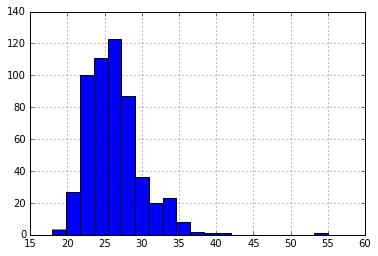

In [88]:
df.drop_duplicates(subset=['iid']).age.hist(bins=20)

In [89]:
df.drop_duplicates('iid').age.isnull().sum()

8

In [90]:
df = df.dropna(subset=['age'])

**field:**
field of study

**field_cd:**
field coded - это уже закодированные сферы интересов, так что просто field удаляем

In [91]:
for i, group in df.groupby('field_cd'):
    print('=' * 10)
    print('Field Code {}'.format(i))
    print(group.field.unique())

Field Code 1.0
['Law' 'law' 'LAW' 'Law and Social Work'
 'Law and English Literature (J.D./Ph.D.)' 'Intellectual Property Law'
 'Law/Business']
Field Code 2.0
['Economics' 'Mathematics' 'Statistics' 'math' 'Mathematics, PhD' 'Stats'
 'math of finance' 'Math']
Field Code 3.0
['Psychology' 'Speech Language Pathology' 'Speech Languahe Pathology'
 'Educational Psychology' 'Organizational Psychology' 'psychology'
 'Communications' 'Sociology' 'psychology and english' 'theory'
 'Health policy' 'Clinical Psychology' 'Sociology and Education'
 'sociology' 'Anthropology/Education' 'speech pathology' 'Speech Pathology'
 'Anthropology' 'School Psychology' 'anthropology' 'Counseling Psychology'
 'African-American Studies/History']
Field Code 4.0
['Medicine' 'Art History/medicine'
 'Sociomedical Sciences- School of Public Health' 'Epidemiology'
 'GS Postbacc PreMed' 'medicine']
Field Code 5.0
['Operations Research' 'Mechanical Engineering' 'Engineering'
 'Electrical Engineering' 'Operations Researc

In [92]:
df.field_cd.isnull().sum()

19

In [93]:
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)

In [94]:
df = df.drop(['field'], axis=1)

**field_cd** - это категориальный признак. Закодируем его с помощью one-hot кодирования.

In [95]:
field_cd_onehot = pd.get_dummies(df.field_cd)

df = df.drop('field_cd',axis = 1)

df = df.join(field_cd_onehot)

In [96]:
df.columns

Index([     'iid',   'gender',     'wave',    'round',      'pid',    'match',
       'int_corr', 'samerace',      'age', 'undergra',
       ...
             10.0,       11.0,       12.0,       13.0,       14.0,       15.0,
             16.0,       17.0,       18.0,       19.0],
      dtype='object', length=187)

In [97]:
df = df.rename(columns={col: str(col) for col in df.columns})

**undergrd:** school attended for undergraduate degree

C учетом того, что есть **mn_sat:**  Median SAT score for the undergraduate institution where attended, который является числовым, **undergrd** выкидываем.

In [98]:
df.undergra.value_counts().head()

UC Berkeley    107
Harvard        104
Columbia        95
Yale            86
NYU             78
Name: undergra, dtype: int64

In [99]:
df = df.drop(['undergra'], axis=1)

In [100]:
df.mn_sat.value_counts().head()

1,400.00    403
1,430.00    262
1,290.00    190
1,450.00    163
1,340.00    146
Name: mn_sat, dtype: int64

In [101]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)

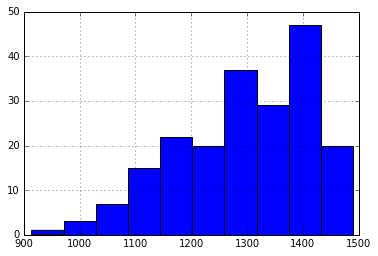

In [102]:
df.drop_duplicates('iid').mn_sat.hist()

In [103]:
df.drop_duplicates('iid').mn_sat.isnull().sum()

342

Отсутствующих значений немало. Заменим их на среднее.

In [104]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].fillna(df.loc[:, 'mn_sat'].dropna().median())

**tuition**: Tuition listed for each response to undergrad in Barron’s 25th Edition college profile book.

In [105]:
df.tuition.value_counts().head()

26,908.00    241
26,019.00    174
15,162.00    138
25,380.00    112
26,062.00    108
Name: tuition, dtype: int64

In [106]:
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)

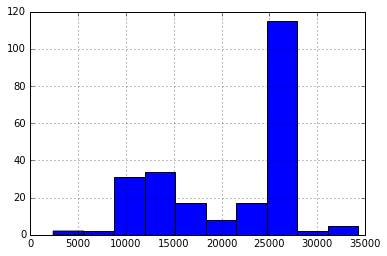

In [107]:
df.drop_duplicates('iid').tuition.hist()

In [108]:
df.drop_duplicates('iid').tuition.isnull().sum()

310

Пропущенных значений немало. Заменим их медианой.

In [109]:
df.loc[:, 'tuition'].dropna().median()

25020.0

In [110]:
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].fillna(df.loc[:, 'tuition'].dropna().median())

**race**:

* Black/African American=1
* European/Caucasian-American=2
* Latino/Hispanic American=3
* Asian/Pacific Islander/Asian-American=4
* Native American=5
* Other=6

In [111]:
df.drop_duplicates('iid').race.isnull().sum()

0

Отсутствующих признаков нет, поэтому сделаем one-hot кодирование. 

In [112]:
races = df.race.unique()
for race in races:
    df.race = df.race.replace(race, str(race) + '_race')

In [113]:
race_onehot = pd.get_dummies(df.race)

df = df.drop('race',axis = 1)

df = df.join(race_onehot)

**imprace**:
How important is it to you (on a scale of 1-10) that a person you date be of the same racial/ethnic background?

**imprelig**:
 How important is it to you (on a scale of 1-10) that a person you date be of the same religious background?


In [114]:
df.drop_duplicates('iid').imprace.isnull().sum()

1

In [116]:
df.drop_duplicates('iid').imprelig.isnull().sum()

1

Просто удалим строки с отсутствующими значениями.

In [117]:
df = df.dropna(subset=['imprelig', 'imprace'])

**from:**
Where are you from originally (before coming to Columbia)? 

**zipcode:**
What was the zip code of the area where you grew up? 

Выкидываем

In [118]:
df = df.drop(['from', 'zipcode'], axis=1)

**income**

In [119]:
df.income.head()

0    69,487.00
1    69,487.00
2    69,487.00
3    69,487.00
4    69,487.00
Name: income, dtype: object

In [120]:
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)

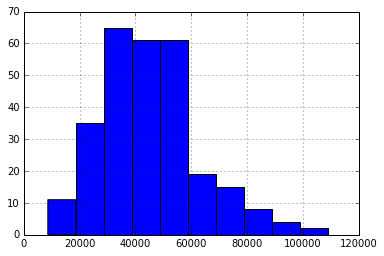

In [121]:
df.drop_duplicates('iid').loc[:, 'income'].hist()

In [122]:
df.drop_duplicates('iid').loc[:, 'income'].isnull().sum()

261

In [123]:
df.income.dropna().median()

43185.0

Заменим на медиану:

In [124]:
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(df.loc[:, 'income'].dropna().median())

**goal**:

    What is your primary goal in participating in this event? 
	Seemed like a fun night out=1
	To meet new people=2
	To get a date=3
	Looking for a serious relationship=4
	To say I did it=5
	Other=6

**date**:

    In general, how frequently do you go on dates? 
	Several times a week=1
	Twice a week=2
	Once a week=3
	Twice a month=4
	Once a month=5
	Several times a year=6
	Almost never=7

**go out**:

    How often do you go out (not necessarily on dates)?
	Several times a week=1
	Twice a week=2
	Once a week=3
	Twice a month=4
	Once a month=5
	Several times a year=6
	Almost never=7

Как бы вы предложили закодировать эти переменные?



In [125]:
df.drop_duplicates('iid').goal.isnull().sum()

0

In [126]:
df.drop_duplicates('iid').date.isnull().sum()

1

Удалим `iid` с отсутствующей `date`.

In [130]:
df = df.dropna(subset=['date'])

In [131]:
df.drop_duplicates('iid')['go_out'].isnull().sum()

0

Цель я бы оставила как есть.

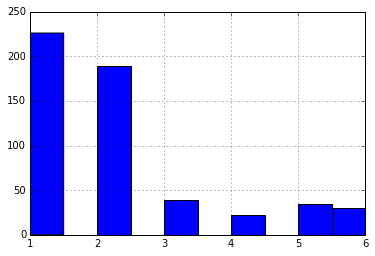

In [132]:
df.drop_duplicates('iid')['goal'].hist()

`date` я разобью на два подмножества: редко (`date` $<=3$) $= 0$, часто (`date` $>3$) $ = 1$

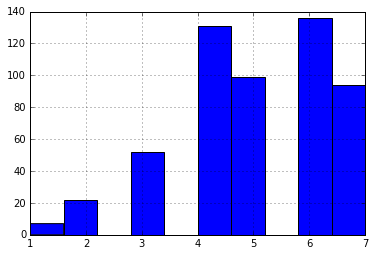

In [133]:
df.drop_duplicates('iid')['date'].hist()

In [134]:
df.loc['date'] = (df['date'] > 3).astype(int)

c:\python35\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Здесь также поступлю.

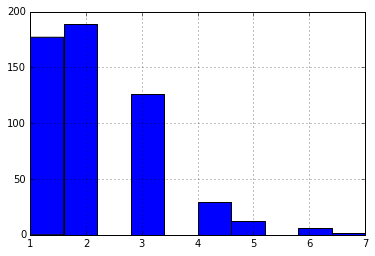

In [138]:
df.drop_duplicates('iid')['go_out'].hist()

In [139]:
df.loc[:,'go_out'] = (df['go_out'] > 3).astype(int)

**career**:
What is your intended career?

**career_c**: 
career coded 

Работаем аналогично field и field_cd

In [140]:
df.career.unique().size

367

In [141]:
df.career_c.unique().size

18

In [142]:
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(19)

In [143]:
df = df.drop(['career'], axis=1)

In [144]:
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(19)

In [145]:
careers = df.career_c.unique()

In [146]:
careers = df.career_c.unique()
for career in careers:
    df.career_c = df.career_c.replace(career, str(career) + '_career')

In [147]:
career_onehot = pd.get_dummies(df.career_c)

df = df.drop('career_c',axis = 1)

df = df.join(career_onehot)

How interested are you in the following activities, on a scale of 1-10?

    sports: Playing sports/ athletics
    tvsports: Watching sports
    excersice: Body building/exercising
    dining: Dining out
    museums: Museums/galleries
    art: Art
    hiking:  Hiking/camping
    gaming: Gaming
    clubbing: Dancing/clubbing
    reading: Reading
    tv: Watching TV
    theater: Theater
    movies: Movies
    concerts: Going to concerts
    music: Music
    shopping: Shopping
    yoga: Yoga/meditation

У нас уже есть признак, который считает корреляцию между интересами пар, так что все выкинем.

In [148]:
df.loc[:, ['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']
      ].isnull().sum()

sports      0
tvsports    0
exercise    0
dining      0
museums     0
art         0
hiking      0
gaming      0
clubbing    0
reading     0
tv          0
theater     0
movies      0
concerts    0
music       0
shopping    0
yoga        0
dtype: int64

In [149]:
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

**exphappy:**
Overall, on a scale of 1-10, how happy do you expect to be with the people you meet 
during the speed-dating event?

**expnum:** 
Out of the 20 people you will meet, how many do you expect will be interested in dating you?

In [150]:
df.drop_duplicates('iid').exphappy.isnull().sum()

0

In [151]:
df.drop_duplicates('iid').expnum.isnull().sum()

416

In [152]:
df = df.drop(['expnum'], axis=1)

#### Attr1. Что анкетируемый ищет от противоположного пола?

We want to know what you look for in the opposite sex. 

Waves 6-9: Please rate the importance of the following attributes in a potential date on a scale of 1-10 (1=not at all important, 10=extremely important):

Waves 1-5, 10-21: You have 100 points to distribute among the following attributes -- give more points to those attributes that are more important in a potential date, and fewer points to those attributes that are less important in a potential date.  Total points must equal 100.

attr1_1 
Attractive

sinc1_1
Sincere

intel1_1
Intelligent

fun1_1
Fun

amb1_1
Ambitious

shar1_1
Has shared interests/hobbies

Итак, получается, что в разных волнах просили по-разному описать, насколько важна каждая черта характера.

Тут нам понадобятся следующие колонки:

In [153]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

In [154]:
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

In [155]:
temp.head(5)

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1
0,1,1,15.0,20.0,20.0,15.0,15.0,15.0
10,2,1,45.0,5.0,25.0,20.0,0.0,5.0
20,3,1,35.0,10.0,35.0,10.0,10.0,0.0
30,4,1,20.0,20.0,20.0,20.0,10.0,10.0
40,5,1,20.0,5.0,25.0,25.0,10.0,15.0


In [156]:
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [157]:
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)

Из-за того, что суммарное число баллов на 6 характеристик разные, нужно привести их к одной шкале.

In [158]:
temp.loc[idx, ]

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,totalsum
918,67,3,20.0,15.0,20.0,20.0,5.0,10.0,90.0
1530,105,4,30.0,15.0,20.0,20.0,0.0,5.0,90.0
7221,489,19,20.0,10.0,20.0,20.0,20.0,0.0,90.0
7586,517,21,15.0,20.0,20.0,20.0,5.0,10.0,90.0
7784,526,21,10.0,10.0,30.0,20.0,10.0,15.0,95.0


In [159]:
idx = ((temp.wave >= 6) & (temp.wave <= 9))

In [160]:
temp.loc[idx, ].head(5)

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,totalsum
1846,132,6,16.67,16.67,16.67,16.67,16.67,16.67,100.02
1851,133,6,12.77,19.15,17.02,17.02,14.89,19.15,100.00
1856,134,6,6.67,20.00,20.00,17.78,20.00,15.56,100.01
1861,135,6,18.18,22.73,18.18,13.64,13.64,13.64,100.01
1871,137,6,17.39,17.39,15.22,17.39,13.04,19.57,100.00


In [161]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

In [162]:
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [163]:
df = df.drop(['temp_totalsum'], axis=1)

#### Attr2. Как вы думаете, чего объект противоположного пола ожидает от человека, с которым идет на свидание?
What do you think the opposite sex looks for in a date?

Waves 6-9: Please rate the importance of the following attributes on a scale of 1-10 (1=not at all important, 10=extremely important):

 Waves 1-5 and 10-21: Please distribute 100 points among the following attributes -- give more points to those attributes that you think are more important to members of the opposite sex when they are deciding whether to date someone.  Total points must equal 100.

    attr2_1  Attractive
    sinc2_1 Sincere
    int2_1 Intelligent
    fun2_1 Fun
    amb2_1 Ambitious
    shar2_1 Has shared interests/hobbies


In [164]:
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

In [165]:
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

In [166]:
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [167]:
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)

In [168]:
temp.loc[idx, ]

,iid,wave,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,totalsum
4816,320,12,20.0,10.0,10.0,10.0,20.0,10.0,80.0


In [169]:
idx = ((temp.wave >= 6) & (temp.wave <= 9))

In [170]:
temp.loc[idx, ].head(10)

,iid,wave,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,totalsum
1846,132,6,22.73,15.91,13.64,15.91,13.64,18.18,100.01
1851,133,6,24.32,16.22,13.51,16.22,10.81,18.92,100.00
1856,134,6,20.51,15.38,12.82,20.51,12.82,17.95,99.99
1861,135,6,18.75,16.67,14.58,18.75,18.75,12.50,100.00
1871,137,6,14.89,17.02,17.02,17.02,14.89,19.15,99.99
1876,138,6,18.37,18.37,16.33,16.33,16.33,14.29,100.02
1881,139,6,19.61,19.61,15.69,19.61,11.76,13.73,100.01
1886,140,6,15.56,17.78,17.78,15.56,15.56,17.78,100.02
1891,141,6,19.05,7.14,19.05,23.81,21.43,9.52,100.00
1896,142,7,19.57,13.04,17.39,19.57,15.22,15.22,100.01


In [171]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)

In [172]:
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [173]:
df = df.drop(['temp_totalsum'], axis=1)

**attr3**: How do you think you measure up?

**attr4**: What you think MOST of your fellow men/women look for in the opposite sex.

**attr5**: How do you think others perceive you?


Признаки `attr4` и `attr5` пока выбросим

In [174]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

#### Вопросы после первого этапа встреч

What you look for in the opposite sex?

    attr1_s
    sinc1_s
    intel1_s
    fun1_s
    amb1_s
    shar1_s

Please rate your opinion of your own attributes, on a scale of 1-10 (1=awful, 10=great) --Be honest!

    attr3_s
    sinc3_s
    intel3_s
    fun3_s
    amb3_s



In [175]:
df.loc[:, ['attr1_s','sinc1_s','intel1_s','fun1_s','amb1_s','shar1_s','attr3_s','sinc3_s',
       'intel3_s','fun3_s','amb3_s']
      ].isnull().sum()

attr1_s     4176
sinc1_s     4176
intel1_s    4176
fun1_s      4176
amb1_s      4176
shar1_s     4176
attr3_s     4272
sinc3_s     4272
intel3_s    4272
fun3_s      4272
amb3_s      4272
dtype: int64

In [176]:
df.index.size

8249

Пропусков безумно много, так что просто удалим эти колонки пока.

In [177]:
df = df.drop(['attr1_s','sinc1_s','intel1_s','fun1_s','amb1_s','shar1_s','attr3_s','sinc3_s',
       'intel3_s','fun3_s','amb3_s'], axis=1)

**satis_2**:
Overall, how satisfied were you with the people you met? (1=not at all satisfied, 10=extremely satisfied)

**length**:

Four minutes is:

	Too little=1
	Too much=2
	Just Right=3

**numdat_2**:
The number of Speed "Dates" you had was:	

	Too few=1
	Too many=2
	Just right=3

Думаю, эти переменные не нужны

In [178]:
df = df.drop(['satis_2','length','numdat_2'], axis=1)

И ещё много-много вопросов:


Now, think back to your yes/no decisions during the Speed Dating event.  Try to distribute the 100 points among these six attributes in the way that best reflects the actual importance of these attributes in your decisions. Total points must equal 100. 

    attr7_2 
    sinc7_2
    intel7_2
    fun7_2
    amb7_2
    shar7_2

We want to know what you look for in the opposite sex. 
Waves 1-5 and 10-21: You have 100 points to distribute among the following attributes -- give more points to those attributes that are more important in a potential date, and fewer points to those attributes that are less important in a potential date.  Total points must equal 100.
Waves 6-9: Please rate the importance of the following attributes in a potential date on a scale of 1-10 (1=not at all important, 10=extremely important): 

    attr1_2 
    sinc1_2
    intel1_2
    fun1_2
    amb1_2

What do you think MOST of your fellow men/women look for in the opposite sex?
You have 100 points to distribute among the following attributes -- give more points to those attributes that you think your fellow men/women find more important in a potential date, and fewer points to those attributes that they find less important in a potential date.
Total points must equal 100.

    attr4_2
    sinc4_2
    intel4_2
    fun4_2
    amb4_2
    shar4_2


What do you think the opposite sex looks for in a date?
Please distribute 100 points among the following attributes -- give more points to those attributes that you think are more important to members of the opposite sex when they are deciding whether to date someone.  Total points must equal 100.

    attr2_2 
    sinc2_2
    intel2_2
    fun2_2
    amb2_2
    shar2_2


How do you think you measure up?
Please rate your opinion of your own attributes, on a scale of 1-10 (1= awful and 10=great).  Be honest!

    attr3_2 
    sinc3_2
    int3_2
    fun3_2
    amb3_2

And finally, how do you think others perceive you?
Please rate yourself how you think others would rate you on each of the following attributes, on a scale of 1-10 (1=awful, 10=great)

    attr5_2 
    sinc5_2
    int5_2
    fun5_2
    amb5_2



In [179]:
feat = ['attr7_2', 'sinc7_2', 'intel7_2',  'fun7_2', 'amb7_2', 'shar7_2', \
        'attr1_2', 'sinc1_2', 'intel1_2', 'fun1_2', 'amb1_2', 'shar1_2', \
        'attr4_2', 'sinc4_2', 'intel4_2', 'fun4_2', 'amb4_2', 'shar4_2', \
        'attr2_2', 'sinc2_2', 'intel2_2', 'fun2_2', 'amb2_2', 'shar2_2', \
        'attr3_2', 'sinc3_2', 'intel3_2', 'fun3_2', 'amb3_2',  \
        'attr5_2', 'sinc5_2', 'intel5_2', 'fun5_2', 'amb5_2', 
       ]

In [180]:
df.loc[:, feat].isnull().sum()

attr7_2     6287
sinc7_2     6316
intel7_2    6287
fun7_2      6287
amb7_2      6316
shar7_2     6297
attr1_2      902
sinc1_2      884
intel1_2     884
fun1_2       884
amb1_2       884
shar1_2      884
attr4_2     2552
sinc4_2     2552
intel4_2    2552
fun4_2      2552
amb4_2      2552
shar4_2     2552
attr2_2     2552
sinc2_2     2552
intel2_2    2552
fun2_2      2552
amb2_2      2552
shar2_2     2552
attr3_2      884
sinc3_2      884
intel3_2     884
fun3_2       884
amb3_2       884
attr5_2     3950
sinc5_2     3950
intel5_2    3950
fun5_2      3950
amb5_2      3950
dtype: int64

Удаляем.

Много пропусков, удаляем.

In [181]:
df = df.drop(feat, axis=1)

#### Вопросы после быстрых свиданий


Of the matches that you received:

     you_call: How many have you contacted to set up a date?
     them_cal: How many have contacted you?

**date_3:**

Have you been on a date with any of your matches?

    Yes=1
    No=2

If you have been on at least one date, please answer the following:

    numdat_3: How many of your matches have you been on a date with so far?
    num_in_3: If yes, how many?

What do you look for in the opposite sex?

    attr1_3 
    sinc1_3
    intel1_3
    fun1_3
    amb1_3
    shar1_3


Now, think back to your yes/no decisions during the night of the Speed Dating event.  Try to distribute the 100 points among these six attributes in the way that best reflects the actual importance of these attributes in your decisions. Give more points to those attributes that were more important in your decisions, and fewer points to those attributes that less less important in your decisions.  Total points must equal 100. 

    attr7_3 
    sinc7_3
    intel7_3
    fun7_3
    amb7_3
    shar7_3



Now we want to know what you think MOST of your fellow men/women look for in the opposite sex. 
Please rate the importance of the following attributes on a scale of 1-10 (1=not at all important, 10=extremely important):

    attr4_3 
    sinc4_3
    intel4_3
    fun4_3
    amb4_3
    shar4_3


What do you think the opposite sex looks for in a date? 
Please rate the importance of the following attributes on a scale of 1-10 (1=not at all important, 10=extremely important):

    attr2_3 
    sinc2_3
    intel2_3
    fun2_3
    amb2_3
    share2_3



Please rate your opinion of your own attributes, on a scale of 1-10 (1= awful and 10=great).  Be honest!

    attr3_3
    sinc3_3
    intel3_3
    fun3_3
    amb3_3

And finally, how do you think others perceive you?
Please rate yourself how you think others would rate you on each of the following attributes, on a scale of 1-10 (1=awful, 10=great)

    attr5_3 
    sinc5_3
    int5_3
    fun5_3
    amb5_3
    
    
Посмотрим, сколько будет пропусков.

In [182]:
feat = ['you_call', 'them_cal',  'date_3', 'numdat_3', 'num_in_3', \
        'attr7_3', 'sinc7_3', 'intel7_3', 'fun7_3', 'amb7_3', 'shar7_3', \
        'attr1_3', 'sinc1_3', 'intel1_3', 'fun1_3', 'amb1_3', 'shar1_3', \
        'attr4_3', 'sinc4_3', 'intel4_3', 'fun4_3', 'amb4_3', 'shar4_3', \
        'attr2_3', 'sinc2_3', 'intel2_3', 'fun2_3', 'amb2_3', 'shar2_3', \
        'attr3_3', 'sinc3_3', 'intel3_3', 'fun3_3', 'amb3_3',  \
        'attr5_3', 'sinc5_3', 'intel5_3', 'fun5_3', 'amb5_3', 
       ]

In [183]:
df.loc[:, feat].isnull().sum()

you_call    4280
them_cal    4280
date_3      4280
numdat_3    6753
num_in_3    7581
attr7_3     6233
sinc7_3     6233
intel7_3    6233
fun7_3      6233
amb7_3      6233
shar7_3     6233
attr1_3     4280
sinc1_3     4280
intel1_3    4280
fun1_3      4280
amb1_3      4280
shar1_3     4280
attr4_3     5295
sinc4_3     5295
intel4_3    5295
fun4_3      5295
amb4_3      5295
shar4_3     5295
attr2_3     5295
sinc2_3     5295
intel2_3    5295
fun2_3      5295
amb2_3      5295
shar2_3     6233
attr3_3     4280
sinc3_3     4280
intel3_3    4280
fun3_3      4280
amb3_3      4280
attr5_3     6233
sinc5_3     6233
intel5_3    6233
fun5_3      6233
amb5_3      6233
dtype: int64

Удаляем:

In [184]:
df = df.drop(feat, axis=1)

In [185]:
df.columns.size

88

In [186]:
df = df.drop(['wave'], axis=1)

In [187]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()

In [209]:
df_male.columns.size

86

In [189]:
df_male.drop_duplicates(subset=['iid']).iid.size

225

In [190]:
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()

In [191]:
df_female.drop_duplicates(subset=['iid']).iid.size

193

In [192]:
df_female.columns = df_female.columns + '_f'

In [207]:
df_female = df_female.rename(columns={'pid_f': 'iid'})

In [208]:
df_female.head(3)

,iid_f,round_f,iid,age_f,mn_sat_f,tuition_f,imprace_f,imprelig_f,income_f,goal_f,...,17.0_career_f,19.0_career_f,2.0_career_f,3.0_career_f,4.0_career_f,5.0_career_f,6.0_career_f,7.0_career_f,8.0_career_f,9.0_career_f
0,1,10,11.0,21.0,1310.0,25020.0,2.0,4.0,69487.0,2.0,...,0,1,0,0,0,0,0,0,0,0
10,2,10,11.0,24.0,1310.0,25020.0,2.0,5.0,65929.0,1.0,...,0,1,0,0,0,0,0,0,0,0
30,4,10,11.0,23.0,1310.0,25020.0,1.0,1.0,37754.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [210]:
df_female = df_female.astype({'iid': 'int32'})

In [211]:
df_final = df_female.join(df_male.set_index('iid'), on='iid')

In [213]:
df_final.head(5)

,iid_f,round_f,iid,age_f,mn_sat_f,tuition_f,imprace_f,imprelig_f,income_f,goal_f,...,17.0_career,19.0_career,2.0_career,3.0_career,4.0_career,5.0_career,6.0_career,7.0_career,8.0_career,9.0_career
0,1,10,11,21.0,1310.0,25020.0,2.0,4.0,69487.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1,10,11,21.0,1310.0,25020.0,2.0,4.0,69487.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1,10,11,21.0,1310.0,25020.0,2.0,4.0,69487.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1,10,11,21.0,1310.0,25020.0,2.0,4.0,69487.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1,10,11,21.0,1310.0,25020.0,2.0,4.0,69487.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Сохраним результат на всякий случай.

In [214]:
df_final.to_csv('data/Speed_datind_processed2.csv', index=False)

In [215]:
dates_target = df_final.dropna()['match']

In [216]:
dates_data = df_final.dropna().drop(['match'], axis=1)

In [218]:
X_train, X_test, y_train, y_test = train_test_split(np.array(dates_data),\
                                                    np.array(dates_target),\
                                                    test_size=0.1,\
                                                    stratify=dates_target)

In [219]:
clf = DecisionTreeClassifier(min_samples_split=2)
my_clf = MyDecisionTreeClassifier(min_samples_split=2)

## Проверка скорости работы на Speed Dating Data 

In [220]:
%time clf.fit(X_train, y_train)

Wall time: 87.9 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [221]:
%time my_clf.fit(np.array(X_train), np.array(y_train))

Wall time: 19.5 s


## Проверка качества работы на Speed Dating Data

In [222]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

1.0

In [223]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

1.0

## Задание 3

Считаю `feature_importances_` как Mean Decrease in Impurity согласно критерию, который выбран.

## Задание 4

Выводим 10 главных фичей для каждого классификатора.

In [253]:
myclf_sorted = np.argsort(my_clf.feature_importances_)[::-1]
clf_sorted = np.argsort(clf.feature_importances_)[::-1]

In [256]:
df_features = pd.DataFrame([
                            dates_data.columns[myclf_sorted],
                            my_clf.feature_importances_[myclf_sorted],
                            dates_data.columns[clf_sorted],
                            clf.feature_importances_[clf_sorted]
                            ],
                            index = [
                                    "feature my_clf",
                                    "feature importace",
                                    "feature sklearn clf",
                                    "feature importance"
                                    ]).T

In [259]:
df_features.head(10)

,feature my_clf,feature importace,feature sklearn clf,feature importance
0,int_corr,1.14994,int_corr,0.328718
1,shar,0.573887,dec,0.196235
2,fun2_1,0.48,round,0.125631
3,amb,0.282376,pid,0.100435
4,sinc,0.277778,fun,0.0641552
5,samerace,0.258291,attr,0.0474015
6,iid,0.2408,shar,0.0445725
7,fun,0.1401,shar2_1,0.0272267
8,attr,0.129012,amb,0.0250867
9,shar2_1,0.105967,fun1_1,0.012281


Половина признаков совпадает. На первом месте у обоих классификаторов корреляция по интересов, что логично. shar, amb, attr, fun - это оценка партнера, по идее тоже естественно, что если человеку не понравился партнер на свидании, вряд ли он захочет с ним продолжать общение.

## Задание 5

С помощью GridSearchCV или RandomSearchCV подберите наиболее оптимальные параметры для случайного леса (Выберете 2-3 параметра). Используем данные Speed Dating Data. Задание реализуйте под пунктом Задание 5 (уже написано ниже)

In [74]:
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import randint as randint
from scipy.stats import uniform

try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV
    from sklearn.cross_validation import StratifiedKFold


RND_SEED = 123

Тут я пробовала отнаследовать base.BaseEstimator, чтобы мой классификатор поддерживал get_params(), но почему-то аргументы не передаются в мой класс все равно.

In [96]:
# Определим пространство поиска

param_grid = {
    #'criterion': ['gini', 'entropy'],
    'max_depth': randint(2, 8),
    'min_samples_split': randint(2, 10),
    }



cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

model = MyDecisionTreeClassifier()
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=200, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=123)
# А дальше, просто .fit()
random_search.fit(X_train, y_train)

invalid criterion name


RuntimeError: No active exception to reraise